In [4]:
# ! pip install scikit-learn
import numpy as np
import pandas as pd
import json
import os
import shutil
import seaborn as sns; sns.set(rc={'figure.figsize':(15,10)})
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
import pickle


In [19]:
import seaborn as sns

<AxesSubplot: >

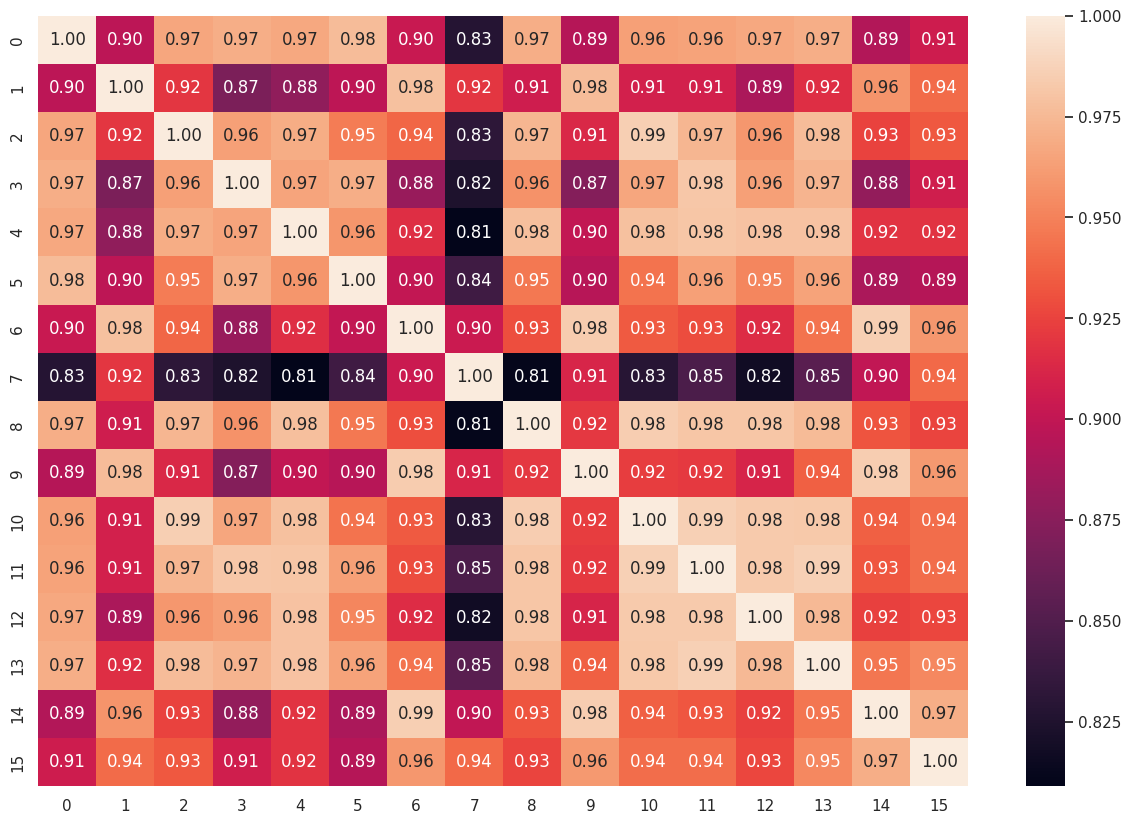

In [23]:
test = d_roi['brain_cat_avg_correl'][:,:,0,0]
sns.heatmap(test, annot=True, fmt=".2f")


In [25]:

file_mat = './data/exp_stats_format/data_fMRI/brain_cat_format_both_best75corr.mat'
file_mat = './data/tolerance_data/humans_rank_rdm_svm.mat'
d_roi = scipy.io.loadmat(file_mat)

In [26]:
d_roi.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rank_diff', 'rank_same', 'rdm_diff', 'rdm_same', 'svm_results'])

In [8]:
d_roi['brain_cat_avg_correl'].shape

(16, 16, 15, 6)

In [210]:
file_mat = './data/tolerance_data/cnn_rank_rdm_resnet50.mat'

In [211]:
d_resnet50 = scipy.io.loadmat(file_mat)

In [215]:
d_resnet50['rdm_results'][0]

array([0.74672687, 0.9283087 , 0.94332239, 0.85401752, 0.82546251,
       0.8759168 ])

# humans

In [181]:
# reliability copied from text
D_REL = {
'size':[.55, .49, .51, .50, .83, .85],
'position':[.23, .30, .31, .48, .72, .78],
'SF' : [.43, .51, .54, .44, .69, .76],
'stats': [.57,.70,.62,.57, .85,.79],
'null': [1, 1, 1, 1, 1, 1]
}
ROIS = ['V1', 'V2', 'V3', 'V4', 'LOT', 'VOT']
EXPS = ['stats', 'position', 'size', 'SF']
# brain x subj x exp



In [189]:
def get_rdm(expname):
    
    RELIABILITY = D_REL[expname]
    exp_index = EXPS.index(expname)
    subjs, rois, rdms = [], [], []
    
    for roi in ROIS:
        roi_index = ROIS.index(roi)
        rel = RELIABILITY[roi_index]
        count = 0
        for s, rdm in enumerate(d_roi['rdm_diff'][roi_index,:,exp_index]):
            if rdm != 0:
                count +=1
                rdm =  rdm/rel
                rdms.append(rdm) 
                rois.append(roi)
                subjs.append(s)

        rdms = list(np.clip(rdms, a_min=-1, a_max=1)) #clip
#         print('# of subjects', count)


    df_rdm = pd.DataFrame()
    df_rdm['roi'] = rois
    df_rdm['subj'] = subjs
    df_rdm['rdm'] = rdms

    df_rdm['roi'] = df_rdm['roi'].astype('category')
    df_rdm['roi'] = df_rdm['roi'].cat.reorder_categories(ROIS)

    df_rdm_mean = df_rdm.groupby(["roi"])["rdm"].agg([np.mean, np.std])
    display(df_rdm_mean)

    N = df_rdm['subj'].nunique()
    x = df_rdm_mean.index
    y = df_rdm_mean["mean"]
    error = df_rdm_mean["std"]/np.sqrt(N-1)
    
    return x, y, error

In [218]:
import json
filename = 'euc-pearson-all'
with open(f'./results/{filename}.json', 'r') as f:
    d_result = json.load(f)

In [203]:
d_result

{'exp_sf': [0.6994818652849741,
  0.8341968911917099,
  0.8797927461139897,
  0.8404145077720206,
  0.6829015544041451,
  0.6373056994818652],
 'exp_position': [0.9717223650385604,
  0.9893499816378993,
  0.9731913330885054,
  0.919573999265516,
  0.7796547925082629,
  0.7609254498714653],
 'exp_size': [0.8839515240543517,
  0.9577671685640837,
  0.9019463826661769,
  0.87146529562982,
  0.7062063900110173,
  0.6845391112743298],
 'exp_stats': [0.9103929489533602,
  0.9107601909658464,
  0.908189496878443,
  0.7822254865956666,
  0.45684906353286814,
  0.5126698494307749]}

,mean,std
roi,,
V1,-0.092641,0.691063
V2,0.054370,0.605094
V3,0.124603,0.280716
V4,0.301766,0.487730
LOT,0.648283,0.291480
VOT,0.664940,0.200020


,mean,std
roi,,
V1,0.271753,0.479770
V2,0.320704,0.516391
V3,0.337418,0.367671
V4,0.676753,0.389779
LOT,0.868465,0.193556
VOT,0.937741,0.085029


,mean,std
roi,,
V1,0.811825,0.292207
V2,0.877160,0.121506
V3,0.806231,0.068636
V4,0.808482,0.239970
LOT,0.945384,0.097711
VOT,0.980447,0.047895


,mean,std
roi,,
V1,0.481478,0.501352
V2,0.554342,0.422197
V3,0.468386,0.506960
V4,0.576542,0.520245
LOT,0.901501,0.192282
VOT,0.846100,0.193982


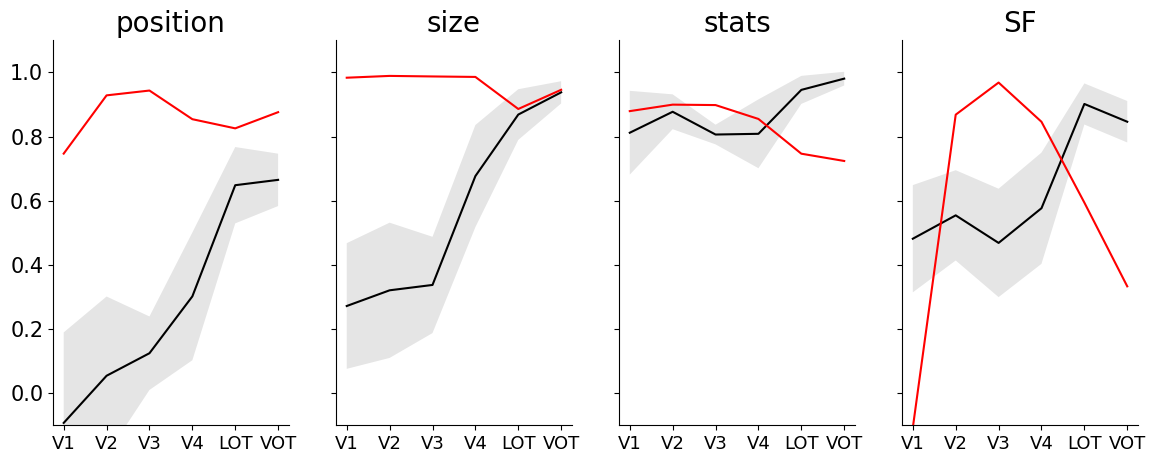

In [220]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (14,5)

N_COL = 4
fig, axes = plt.subplots(nrows=1, ncols=N_COL,  sharey=True)

for i, exp in enumerate(['position', 'size', 'stats','SF']):
    x, y, error = get_rdm(exp)
    axes[i].plot(x, y, 'black')
#     axes[i].plot(x, d_result['exp_'+exp.lower()], 'blue')
    axes[i].plot(x, d_resnet50['rdm_results'][i], 'red')
    
    axes[i].fill_between(x, y-error, y+error, alpha=0.1, facecolor='black')
    axes[i].set_title(exp, fontsize=20)
    axes[i].set_ylim(-0.1,1.1)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=13)
    
plt.show()



In [221]:
import json
filename = 'euc-spearman-all'
with open(f'./results/imagenet-16/{filename}.json', 'r') as f:
    d_result = json.load(f)

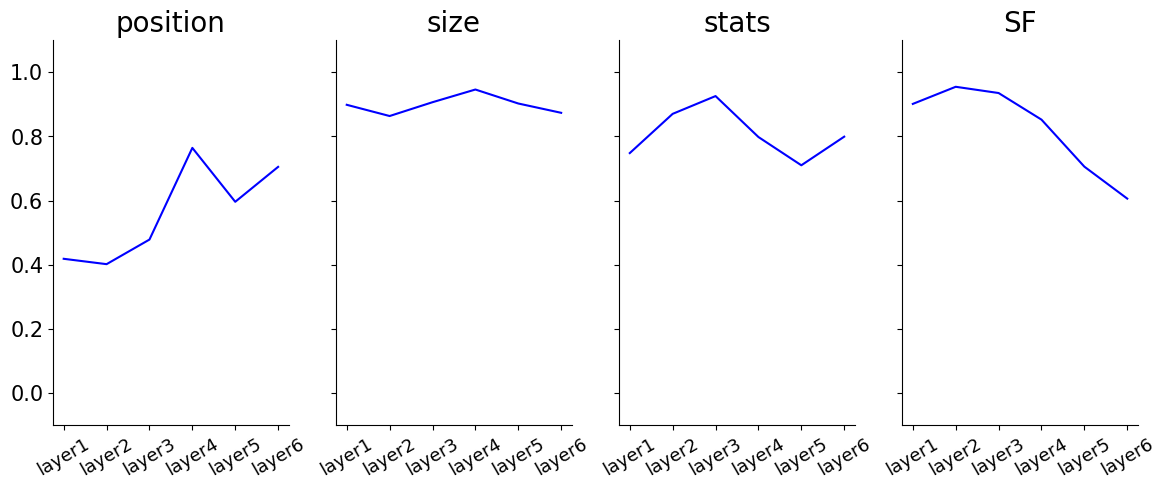

In [225]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (14,5)

N_COL = 4
fig, axes = plt.subplots(nrows=1, ncols=N_COL,  sharey=True)

x= ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
for i, exp in enumerate(['position', 'size', 'stats','SF']):
    axes[i].plot(x, d_result['exp_'+exp.lower()], 'blue')

    
#     axes[i].fill_between(x, y-error, y+error, alpha=0.1, facecolor='black')
    axes[i].set_title(exp, fontsize=20)
    axes[i].set_ylim(-0.1,1.1)
    axes[i].spines.right.set_visible(False)
    axes[i].spines.top.set_visible(False)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].tick_params(axis='x', labelsize=13, rotation=30)
    
plt.show()